# HW 3

## Problem 1

In [84]:
from matplotlib import pyplot as plt
import numpy as np

In [85]:
Omega_m0 = .3
Omega_lambda = .7

def omega_m(z):
    return (Omega_m0*(1+z)**3) / (Omega_m0*(1+z)**3 + Omega_lambda)

def delta_vir(z):
    return 18*np.pi**2 + 82*(omega_m(z)-1) - 39*(omega_m(z)-1)**2

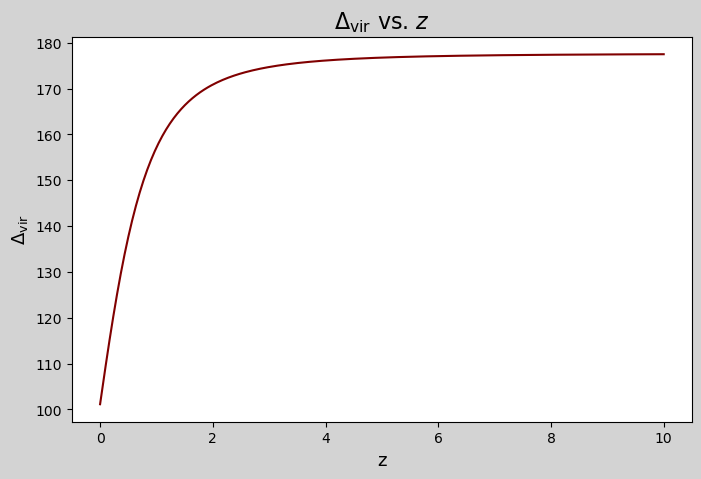

In [86]:
zs = np.linspace(0,10,300)
delta_virs = delta_vir(zs)

fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title("$\Delta_{\mathrm{vir}}$ vs. $z$", fontsize=16)
ax.set_xlabel('z', fontsize=13)
ax.set_ylabel("$\Delta_{\mathrm{vir}}$", fontsize=13)
ax.plot(zs, delta_virs, c="maroon")

In [87]:
h = .7 #
H_0 = 100*h #km s^-1 Mpc^-1
H_0 = H_0 / 3.09e19 # s^-1
G = 6.67*10**-8 # cm^3 g^-1 s^-2
M = 1e12 * 1.989e33 # g

def rho_crit(z):
    return 3 * H_0**2 * (Omega_m0*(1+z)**3 + Omega_lambda)/(8*np.pi*G)

def r_vir(M, z):
    # give M in grams
    return ((.75*M) / (rho_crit(z)*delta_vir(z))*np.pi*omega_m(z))**(1/3)

z	r_vir [cm]
0	1.15e+24
1	9.33e+23
3	5.21e+23
6	3.02e+23
10	1.93e+23


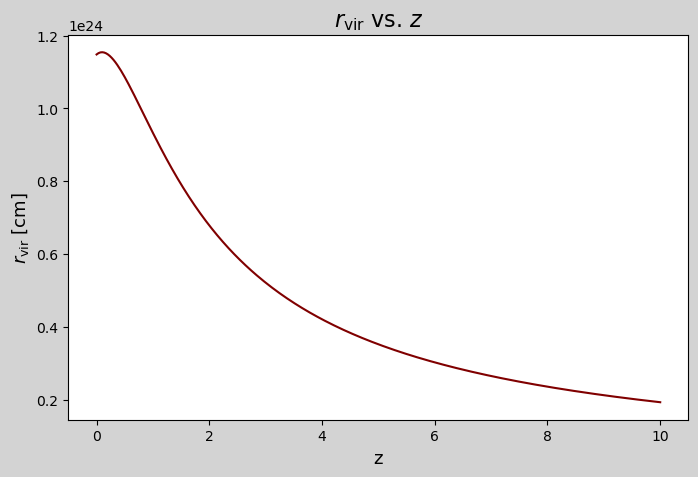

In [139]:
r_virs = r_vir(M, zs)

fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title("$r_{\mathrm{vir}}$ vs. $z$", fontsize=16)
ax.set_xlabel('z', fontsize=13)
ax.set_ylabel("$r_{\mathrm{vir}}$ [cm]", fontsize=13)
ax.plot(zs, r_virs, c="maroon")

notable_zs = [0,1,3,6,10]
print("z\tr_vir [cm]")
for z in notable_zs:
    print(f"{z}\t{r_vir(M,z):.2e}")

## Problem 2

In [89]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
cosmo = cosmology.setCosmology('planck15')

In [90]:
def rho(r, z=0, M=M):
    c_vir = concentration.concentration(M=M/1.989e33, z=z, mdef="vir", model="diemer15_orig")
    denom = 4 * np.pi * (r_vir(M,z)/c_vir)**3 * (np.log(1+c_vir) - c_vir/(1+c_vir))
    denom *= (c_vir/r_vir(M,z)) * r * (1+(c_vir/r_vir(M,z))*r)**2

    return M / denom

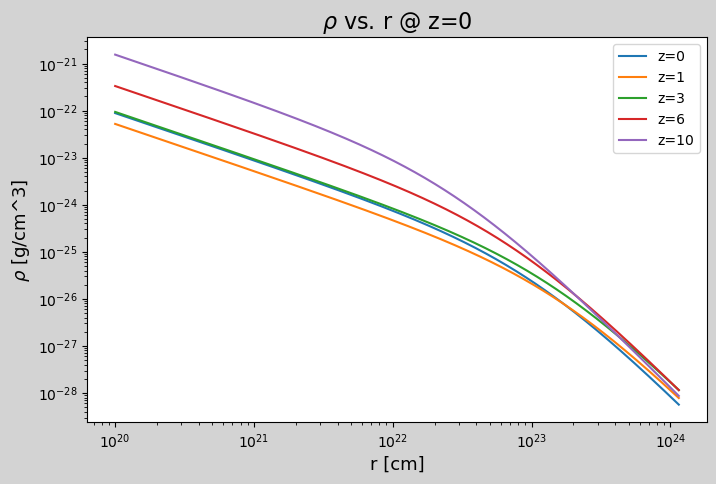

In [140]:
fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title(r"$\rho$ vs. r @ z=0", fontsize=16)
ax.set_xlabel('r [cm]', fontsize=13)
ax.set_ylabel(r"$\rho$ [g/cm^3]", fontsize=13)
ax.set_yscale('log')
ax.set_xscale('log')

rs = np.logspace(20, np.log10(r_vir(M,0)), 10000)

for z in notable_zs:
    rhos = rho(rs, z=z)
    ax.plot(rs, rhos, label=f"z={z}")

ax.legend()

In [92]:
from scipy import interpolate

def r_d(d=200, M=M, z=0):
    rs = np.logspace(20, np.log10(r_vir(M,0)), 10000)
    rhos = rho(rs, z=z)
    r = interpolate.interp1d(rhos, rs)

    rho_d = d*omega_m(z)*rho_crit(z)
    return r(rho_d)

In [129]:
this_r_vir = r_vir(M,0)
print(f"r_vir = {this_r_vir:.2e} cm\nz = 0\n")
print("d\t\tr_d [cm]\t\tr_d/r_vir")
for d in [200,500,2500]:
    this_r_d = r_d(d=d)
    print(f"{d}\t\t{this_r_d:.2e}\t\t{this_r_d/this_r_vir:.2f}")


r_vir = 1.15e+24 cm
z = 0

d		r_d [cm]		r_d/r_vir
200		5.02e+23		0.44
500		3.52e+23		0.31
2500		1.80e+23		0.16


In [130]:
z=6
this_r_vir = r_vir(M,z)
print(f"r_vir = {this_r_vir:.2e}\nz = 6\n")
print("d\t\tr_d [cm]\t\tr_d/r_vir")
for d in [200,500,2500]:
    this_r_d = r_d(d=d,z=z)
    print(f"{d}\t\t{this_r_d:.2e}\t\t{this_r_d/this_r_vir:.2f}")

r_vir = 3.02e+23
z = 6

d		r_d [cm]		r_d/r_vir
200		5.78e+22		0.19
500		3.40e+22		0.11
2500		1.09e+22		0.04


In [108]:
from scipy.integrate import quad

def m_internal(r):
    def integrand(r):
        return 4*np.pi * r**2 * rho(r)
    return quad(integrand, 0, r,)[0]

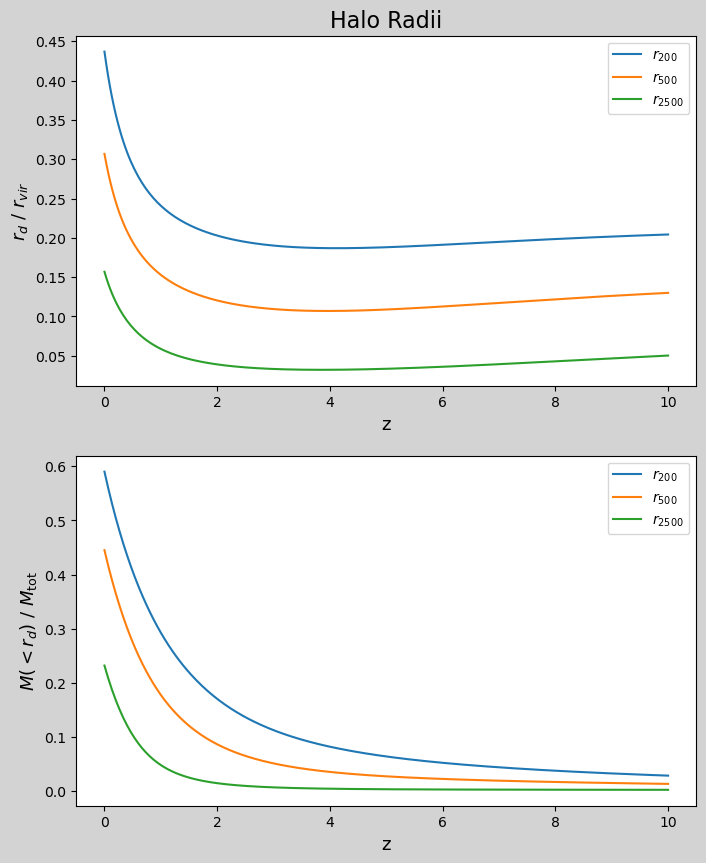

In [138]:
zs = np.linspace(0,10,300)
r_virs = r_vir(M,zs)
ds = [200,500,2500]
r_200s = [r_d(d=200,z=z) for z in zs]


fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(8,10))
fig.set_facecolor('lightgray')
axes[0].set_title("Halo Radii", fontsize=16)
axes[0].set_xlabel('z', fontsize=13)
axes[0].set_ylabel("$r_d$ / $r_{vir}$", fontsize=13)

axes[1].set_xlabel('z', fontsize=13)
axes[1].set_ylabel("$M(<r_d)$ / $M_{\mathrm{tot}}$", fontsize=13)

for d in ds:
    r_ds = [r_d(d=d,z=z) for z in zs]
    Ms = np.array([m_internal(r) for r in r_ds])
    axes[0].plot(zs, r_ds/r_virs, label=f"$r_{{{d}}}$")
    axes[1].plot(zs, Ms/M, label=f"$r_{{{d}}}$")
    
axes[0].legend()
axes[1].legend()

In [134]:
z = 0
this_r_vir = r_vir(M,z)
print(f"M = {M:.2e} g, z = {z}\n")
print("d\t\tM(<r_d) [g]\t\tM(<r_d)/M_tot")
for d in [200,500,2500]:
    this_r_d = r_d(d=d,z=z)
    m_int = m_internal(this_r_d)
    print(f"{d}\t\t{m_int:.2e}\t\t{m_int/M:.2f}")


M = 1.99e+45 g, z = 0

d		M(<r_d) [g]		M(<r_d)/M_tot
200		1.17e+45		0.59
500		8.85e+44		0.45
2500		4.61e+44		0.23


In [135]:
z = 6
this_r_vir = r_vir(M,z)
print(f"M = {M:.2e} g, z = {z}\n")
print("d\t\tM(<r_d) [g]\t\tM(<r_d)/M_tot")
for d in [200,500,2500]:
    this_r_d = r_d(d=d,z=z)
    m_int = m_internal(this_r_d)
    print(f"{d}\t\t{m_int:.2e}\t\t{m_int/M:.2f}")

M = 1.99e+45 g, z = 6

d		M(<r_d) [g]		M(<r_d)/M_tot
200		1.04e+44		0.05
500		4.46e+43		0.02
2500		5.80e+42		0.00


## Problem 3